# Only use competicion data for both fine-tuning and final classification

Data used for fine-tuning and final classification :

* corpus completo 5 temas - 08-sep-2016 - codificacion 5 temas.csv (competition)

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import sys
from fastai.text import *
import html
import json

import pandas as pd
import numpy as np
from google_drive_downloader import GoogleDriveDownloader as gdd
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix

np.random.seed(52)

In [2]:
DATA_PATH=Path('./DATA/2017')
# DATA_PATH=Path('./data/election_tweets')

WIKILM_PATH=Path('./WIKI_LM/LM')
PRE_FINETUNE_PATH=Path('./FINETUNE/2017/')

TWEETSLM_PATH=Path('./TWEETS_LM/2017')
CLAS_PATH=Path('./TWEETS_CLAS/2017')

BOS = 'xbos'  # beginning-of-sentence tag
FLD = 'xfld'  # data field tag

## Prepare Data

In [4]:
df_trn = pd.read_csv(DATA_PATH/'train_ext.csv', header=None)
df_val = pd.read_csv(DATA_PATH/'validation.csv', header=None)
df_tst = pd.read_csv(DATA_PATH/'test.csv', header=None)
df_gen = pd.read_csv(DATA_PATH/'general.csv', header=None)

In [5]:
df_trn.describe()

,0
count,1552.000000
mean,1.525129
std,1.151631
min,0.000000
25%,0.000000
50%,2.000000
75%,3.000000
max,3.000000


In [6]:
tweets = np.concatenate([df_trn, df_val, df_gen])
tweets_tst = np.concatenate([df_tst])
del df_trn, df_val, df_tst, df_gen

tweets[:5]

array([[0,
        '@myendlesshazza a. que puto mal escribo\n\nb. me sigo surrando help \n\n3. ha quedado raro el "cómetelo" ahí JAJAJAJA'],
       [0,
        '@estherct209 jajajaja la tuya y la d mucha gente seguro!! Pero yo no puedo sin mi melena me muero'],
       [0, 'Vale he visto la tia bebiendose su regla y me hs dado muchs grima'],
       [0,
        'Se ha terminado #Rio2016 Lamentablemente no arriendo las ganancias al pueblo brasileño por la penuria que les espera \nSuerte y solidaridad'],
       [0, '@toNi_end seria mejor que dejasen de emitir esa basura ya  hay que evolucionar para bien y eso']],
      dtype=object)

In [7]:
np.random.shuffle(tweets)
tweets[:5]

array([[0,
        '@aaron_np @OjeraFarlopera_ @livetodie77 @Nerea_RMCF93 no tenemos para cerveza, somos pobres y sucios. No nos dejan entrar al bar '],
       [0,
        'En @SextaNoticias estamos buscando a este estudiante agredido por un Policía en Valencia http://t.co/wJnwBuNO #Ayuda'],
       [1,
        'Fui a ver el nuevo espectaculo del Cirque du Soleil sobre la obra del genial "Michael (cont) http://t.co/OSf16mUA'],
       [0,
        'Anoche en la calle miles de personas x los servicios públicos. ¿preludio d la huelga general q dijo Rajoy le costaría la Reforma Laboral?'],
       [1,
        '#FF RT @patriestevez: @maruhuevar @JoseMacill72 @GuillermoUtrera @anaroski @mariviromero @au_auxiliadora @MSacra todos a una #votaPP oleee']],
      dtype=object)

In [8]:
def flattern(A):
    'Source: https://stackoverflow.com/a/17867797/7273299'
    
    'Flattens a list of lists and strings into a list.'
    rt = []
    for i in A:
        if isinstance(i,list): rt.extend(flattern(i))
        else: rt.append(i)
    return rt

def isInt(v):
    'Source: https://stackoverflow.com/a/9859202/7273299'
    
    'Checks if a string is a number.'
    try:     i = int(v)
    except:  return False
    return True

def char_count(word, chars, lbound=2):
    char_count = [word.count(char) for char in chars]
    return all(i >= lbound for i in char_count)

def replace_lol(repl_str, texts):
    for string, chars in repl_str:
        texts = [[[string] if char_count(i, set(chars), 2) else i for i in text.split()] for text in texts]
        texts = np.array([flattern(text) for text in texts])
        texts = np.array([' '.join(text) for text in texts])
    return texts

def preprocess_tweets(tweets):
    """
    twitter specific text processing and shuffle
    """
    # Remove \n
    tweets = np.array([str(i).replace('\n','') for i in tweets])
    tweets = np.array([str(i).replace('&lt;','') for i in tweets])
    tweets = np.array([str(i).replace('&gt;','') for i in tweets])
    
    # Placeholders for hyperlinks and user references
    tweets = [['hyp_link' if i.startswith('http') 
               else 'user_ref' if i.startswith('@')
               else 'hash_tag' if i.startswith('#')
               else i for i in tweet.split()] for tweet in tweets]
    tweets = np.array([' '.join(i) for i in tweets])

    # Prefix for integers
    tweets = [[['int_string'] if isInt(i) 
               else i for i in tweet.split()] for tweet in tweets]
    tweets = np.array([flattern(tweet) for tweet in tweets])
    tweets = np.array([' '.join(i) for i in tweets])

    # Prefix for slang
    tweets = [[['que'] if i in ['q', 'k', 'qu', 'ke', 'qe'] 
               else ['por'] if i=='x' 
               else ['porque'] if i in ['xq', 'pq', 'porq'] 
               else ['de'] if i=='d' 
               else ['te'] if i=='t'
               else ['también'] if i=='tb'
               else ['Que'] if i in ['Q', 'K', 'Qu','Ke', 'Qe'] 
               else ['Por'] if i=='X'
               else ['Porque'] if i in ['Xq', 'Pq', 'Porq'] 
               else ['De'] if i=='D' 
               else ['Te'] if i=='T'
               else ['También'] if i=='Tb'
               else i for i in tweet.split()] for tweet in tweets]
    tweets = np.array([flattern(tweet) for tweet in tweets])
    tweets = np.array([' '.join(i) for i in tweets])

    # Lol type characters
    repl_str = [('risa_ja','ja'), ('risa_ji','ji'), ('risa_je','je'), ('risa_jo','jo'), ('risa_ju', 'ju'),
               ('risa_ja','aj'), ('risa_ji','ij'), ('risa_ju', 'uj'), ('risa_ja', 'lol')]

    # Adding prefix to lol type characters
    tweets = replace_lol(repl_str, tweets)

    return tweets


In [9]:
tweets[:,1] = preprocess_tweets(tweets[:,1])
tweets_tst[:,1] = preprocess_tweets(tweets_tst[:,1])

In [10]:
tweets[:5]

array([[0,
        'user_ref user_ref user_ref user_ref no tenemos para cerveza, somos pobres y sucios. No nos dejan entrar al bar'],
       [0,
        'En user_ref estamos buscando a este estudiante agredido por un Policía en Valencia hyp_link hash_tag'],
       [1,
        'Fui a ver el nuevo espectaculo del Cirque du Soleil sobre la obra del genial "Michael (cont) hyp_link'],
       [0,
        'Anoche en la calle miles de personas por los servicios públicos. ¿preludio de la huelga general que dijo Rajoy le costaría la Reforma Laboral?'],
       [1,
        'hash_tag RT user_ref user_ref user_ref user_ref user_ref user_ref user_ref user_ref todos a una hash_tag oleee']],
      dtype=object)

In [11]:
# NEGA_train_docs = [tweets[i] for i in range(len(tweets)) if tweets[i, 0] == 0]
# POSI_train_docs = [tweets[i] for i in range(len(tweets)) if tweets[i, 0] == 1]
# NEUT_train_docs = [tweets[i] for i in range(len(tweets)) if tweets[i, 0] == 2]
# NONE_train_docs = [tweets[i] for i in range(len(tweets)) if tweets[i, 0] == 3]
# del tweets

# level_train_docs = [NEGA_train_docs,POSI_train_docs,NEUT_train_docs,NONE_train_docs]

# fmt = """Negative Sentences = {:d}
#        \rPositive Sentences = {:d}
#        \rNeutral  Sentences = {:d}
#        \rNone Values        = {:d}"""

# print(fmt.format(len(NEGA_train_docs),
#                  len(POSI_train_docs),
#                  len(NEUT_train_docs),
#                  len(NONE_train_docs)))

# maxSentLvl = max(len(POSI_train_docs),len(NEGA_train_docs),len(NEUT_train_docs),len(NONE_train_docs))

# print('Maximum number of sentences per level : ', maxSentLvl)


In [12]:
# from googletrans import Translator
# import random

# translator = Translator()
# tweets_bal = []
# for i in range(len(level_train_docs)):
#     level_per = np.array(random.sample(level_train_docs[i],maxSentLvl-len(level_train_docs[i])))
#     tweets_bal.append(level_per[:minSentLvl])
    
# print("New size of sentences:\n")
# fmt = """Negative Sentences = {:d}
#        \rPositive Sentences = {:d}
#        \rNeutral  Sentences = {:d}
#        \rNone Values        = {:d}"""

# print(fmt.format(len(tweets_bal[0]),
#                  len(tweets_bal[1]),
#                  len(tweets_bal[2]),
#                  len(tweets_bal[3])))

# # flat_tweets_bal = [item for sublist in tweets_bal for item in sublist]
# # shuf_tweets_bal = random.sample(flat_tweets_bal,len(flat_tweets_bal))

# # assert (len(shuf_tweets_bal) == 4 * minSentLvl)
# # print("shuf_tweets_bal size = ", len(shuf_tweets_bal))

# # shuf_tweets_bal = np.array(shuf_tweets_bal)
# # print(shuf_tweets_bal[:5])

In [13]:
col_names = ['label', 'tweet']

In [14]:
tweets_train, tweets_valid, labels_train, labels_valid = train_test_split(
                                                    tweets[:,1], tweets[:,0],
                                                    stratify=tweets[:,0], 
                                                    test_size=0.10)

# tweets_train, tweets_valid, labels_train, labels_valid = train_test_split(
#                                                     shuf_tweets_bal[:,1], shuf_tweets_bal[:,0],
#                                                     stratify=shuf_tweets_bal[:,0], 
#                                                     test_size=0.10)

print('train shapes:', tweets_train.shape, labels_train.shape)
print('valid shapes:', tweets_valid.shape, labels_valid.shape)
print('test shapes:', tweets_tst.shape)

train shapes: (8348,) (8348,)
valid shapes: (928,) (928,)
test shapes: (1899, 2)


In [15]:
df_trn = pd.DataFrame({'tweet':tweets_train, 'label':labels_train}, columns=col_names)
df_val = pd.DataFrame({'tweet':tweets_valid, 'label':labels_valid}, columns=col_names)
df_tst = pd.DataFrame({'tweet':tweets_tst[:,1], 'label':tweets_tst[:,0]}, columns=col_names)

In [16]:
print(df_trn['label'].value_counts())
print(df_val['label'].value_counts())
print(df_tst['label'].value_counts())

1    3022
0    2537
3    1765
2    1024
Name: label, dtype: int64
1    336
0    282
3    196
2    114
Name: label, dtype: int64
Series([], Name: label, dtype: int64)


In [17]:
def balance_df(df):
    lst = [df]
    max_size = df['label'].value_counts().max()
    for class_index, group in df.groupby('label'):
        lst.append(group.sample(max_size-len(group), replace=True))
    df = pd.concat(lst)
    return df

df_trn = balance_df(df_trn)

print(df_trn['label'].value_counts())
print(df_val['label'].value_counts())
print(df_tst['label'].value_counts())

3    3022
2    3022
1    3022
0    3022
Name: label, dtype: int64
1    336
0    282
3    196
2    114
Name: label, dtype: int64
Series([], Name: label, dtype: int64)


In [18]:
df_trn.to_csv(CLAS_PATH/'train.csv', header=False, index=False)
df_val.to_csv(CLAS_PATH/'validation.csv', header=False, index=False)
df_tst.to_csv(CLAS_PATH/'test.csv', header=False, index=False)
df_trn.shape, df_val.shape
# (CLAS_PATH/'classes.txt').open('w').writelines(f'{o}\n' for o in LABELS)

((12088, 2), (928, 2))

### Create dataframes for Language Model fine-tuning

In [19]:
tweets_lm = np.concatenate([tweets_train, tweets_valid, tweets_tst[:,1]])
labels_lm = np.concatenate([labels_train, labels_valid, [0]*len(tweets_tst[:,0])])

tweets_train_lm, tweets_valid_lm, labels_train_lm, labels_valid_lm = train_test_split(
                                                    tweets_lm, labels_lm,
                                                    stratify=labels_lm, 
                                                    test_size=0.10)

In [20]:
df_trn = pd.DataFrame({'tweet':tweets_train_lm, 'label':[0]*len(tweets_train_lm)}, columns=col_names)
df_val = pd.DataFrame({'tweet':tweets_valid_lm, 'label':[0]*len(tweets_valid_lm)}, columns=col_names)

In [21]:
df_trn.to_csv(TWEETSLM_PATH/'train.csv', header=False, index=False)
df_val.to_csv(TWEETSLM_PATH/'validation.csv', header=False, index=False)

In [22]:
df_trn.shape, df_val.shape

((10057, 2), (1118, 2))

## Tokenize and Standarize General Tokens


In [23]:
chunksize=24000

re1 = re.compile(r'  +')

In [24]:
def fixup(x):
    x = x.replace('#39;', "'").replace('amp;', '&').replace('#146;', "'").replace(
        'nbsp;', ' ').replace('#36;', '$').replace('\\n', "\n").replace('quot;', "'").replace(
        '<br />', "\n").replace('\\"', '"').replace('<unk>','u_n').replace(' @.@ ','.').replace(
        ' @-@ ','-').replace('\\', ' \\ ')
    return re1.sub(' ', html.unescape(x))

def get_texts(df, n_lbls=1):
    labels = df.iloc[:,range(n_lbls)].values.astype(np.int64)
    texts = f'\n{BOS} ' + df[n_lbls].astype(str)
    for i in range(n_lbls+1, len(df.columns)): texts += f' {FLD} {i-n_lbls} ' + df[i].astype(str)
    texts = texts.apply(fixup).values.astype(str)

    tok = Tokenizer(lang='es').proc_all_mp(partition_by_cores(texts), lang='es')
    return tok, list(labels)

def get_all(df, n_lbls):
    tok, labels = [], []
#     print(df)
    for i, r in enumerate(df):
        tok_, labels_ = get_texts(r, n_lbls)
        tok += tok_;
        labels += labels_
    return tok, labels

In [25]:
df_trn = pd.read_csv(TWEETSLM_PATH/'train.csv', header=None, chunksize=chunksize)
df_val = pd.read_csv(TWEETSLM_PATH/'validation.csv', header=None, chunksize=chunksize)

In [26]:
tok_trn, trn_labels = get_all(df_trn, 1)
tok_val, val_labels = get_all(df_val, 1)

In [27]:
len(tok_trn),len(trn_labels), len(tok_val), len(val_labels)

(10057, 10057, 1118, 1118)

In [28]:
print(tok_trn[:2])

[['\n', 'xbos', 'entramos', 'ya', 'tk_rep', '4', '!', 'user_ref', '20:30', 'no', 'somos', 'telesucesos', ',', 'si', 'quiere', 'información', 'con', 'criterio', ',', 'este', 'es', 'su', 'telediario', '.', 'vamos', 'tk_rep', '5', '!'], ['\n', 'xbos', 'una', 'cosa', 'es', 'jugar', 'int_string', 'y', 'otra', 'un', 'equipo', 'de', '11', '.']]


In [29]:
(TWEETSLM_PATH/'tmp').mkdir(exist_ok=True)

In [30]:
np.save(TWEETSLM_PATH/'tmp'/'tok_trn.npy', tok_trn)
np.save(TWEETSLM_PATH/'tmp'/'tok_val.npy', tok_val)

In [31]:
tok_trn = np.load(TWEETSLM_PATH/'tmp'/'tok_trn.npy')
tok_val = np.load(TWEETSLM_PATH/'tmp'/'tok_val.npy')

In [32]:
freq = Counter(p for o in tok_trn for p in o)
freq.most_common(20)

[('\n', 10057),
 ('xbos', 10057),
 ('de', 7097),
 ('user_ref', 6155),
 ('.', 5026),
 (',', 4674),
 ('que', 4592),
 ('la', 4416),
 ('el', 4016),
 ('en', 3703),
 ('a', 3663),
 ('y', 3595),
 ('!', 2863),
 ('hyp_link', 2382),
 ('no', 2223),
 ('"', 1846),
 ('hash_tag', 1814),
 ('es', 1705),
 ('t_up', 1701),
 ('los', 1601)]

In [33]:
max_vocab = 60000
min_freq = 1

In [34]:
itos = [o for o,c in freq.most_common(max_vocab) if c>min_freq]
itos.insert(0, '_pad_')
itos.insert(0, '_unk_')

stoi = collections.defaultdict(lambda:0, {v:k for k,v in enumerate(itos)})
len(itos)

8321

In [35]:
trn_lm = np.array([[stoi[o] for o in p] for p in tok_trn])
val_lm = np.array([[stoi[o] for o in p] for p in tok_val])

In [36]:
np.save(TWEETSLM_PATH/'tmp'/'trn_ids.npy', trn_lm)
np.save(TWEETSLM_PATH/'tmp'/'val_ids.npy', val_lm)
pickle.dump(itos, open(TWEETSLM_PATH/'tmp'/'itos.pkl', 'wb'))

## Load Encoder Weights for Language Model

In [37]:
BACKBONE_MODEL = PRE_FINETUNE_PATH/'models/lm1_wgts.h5'

In [38]:
wgts = torch.load(BACKBONE_MODEL, map_location=lambda storage, loc: storage)

We calculate the mean of the layer0 encoder weights. This can be used to assign weights to unknown tokens when we transfer to target IMDB LM.

In [39]:
enc_wgts = to_np(wgts['0.encoder.weight'])
row_m = enc_wgts.mean(0)

In [40]:
itos2 = pickle.load((PRE_FINETUNE_PATH/'tmp'/'itos.pkl').open('rb'))
stoi2 = collections.defaultdict(lambda:-1, {v:k for k,v in enumerate(itos2)})

Before we try to transfer the knowledge from wikitext to the IMDB LM, we match up the vocab words and their indexes. We use the defaultdict container once again, to assign mean weights to unknown IMDB tokens that do not exist in wikitext103.

In [41]:
em_sz,nh,nl = 400,1150,3

In [42]:
trn_lm = np.load(TWEETSLM_PATH/'tmp'/'trn_ids.npy')
val_lm = np.load(TWEETSLM_PATH/'tmp'/'val_ids.npy')
itos = pickle.load(open(TWEETSLM_PATH/'tmp'/'itos.pkl', 'rb'))

In [43]:
vs=len(itos)
vs,len(trn_lm)

(8321, 10057)

In [44]:
new_w = np.zeros((vs, em_sz), dtype=np.float32)
n_replaced_vocab = 0

for i,w in enumerate(itos):
    r = stoi2[w]
    if r>=0 :
        new_w[i] = enc_wgts[r]
        n_replaced_vocab +=1
    else:
        new_w[i] = row_m

print(f'Reuse {n_replaced_vocab} word embeddings from fine-tuning')
print(f'{vs-n_replaced_vocab} where not in vocab from fine-tuning')

Reuse 6787 word embeddings from fine-tuning
1534 where not in vocab from fine-tuning


"We now overwrite the weights into the wgts odict. The decoder module, which we will explore in detail is also loaded with the same weights due to an idea called weight tying."

In [45]:
wgts['0.encoder.weight'] = T(new_w)
wgts['0.encoder_with_dropout.embed.weight'] = T(np.copy(new_w))
wgts['1.decoder.weight'] = T(np.copy(new_w))

## Language Model Finetuning

In [46]:
wd=1e-7
bptt=70
bs=32
em_sz,nh,nl = 400,1150,3
opt_fn = partial(optim.SGD, momentum=0.9)

In [47]:
trn_lm = np.load(TWEETSLM_PATH/'tmp'/'trn_ids.npy')
val_lm = np.load(TWEETSLM_PATH/'tmp'/'val_ids.npy')
trn_lm = np.concatenate(trn_lm)
val_lm = np.concatenate(val_lm)

In [48]:
itos = pickle.load(open(TWEETSLM_PATH/'tmp'/'itos.pkl', 'rb'))
vs = len(itos)

trn_dl = LanguageModelLoader(trn_lm, bs, bptt)
val_dl = LanguageModelLoader(val_lm, bs, bptt)
md = LanguageModelData(TWEETSLM_PATH, 1, vs, trn_dl, val_dl, bs=bs, bptt=bptt)

In [49]:
drops = np.array([0.25, 0.1, 0.2, 0.02, 0.15])*0.7
# drops = np.array([0.25, 0.1, 0.2, 0.02, 0.15])

In [50]:
learn = md.get_model(opt_fn, em_sz, nh, nl, dropouti=drops[0], dropout=drops[1], wdrop=drops[2], dropoute=drops[3], dropouth=drops[4])

learn.metrics = [accuracy]
learn.unfreeze()

In [51]:
learn.model.load_state_dict(wgts)

In [52]:
learn.lr_find2(start_lr=1e-3,end_lr=2e-2, num_it=300)

 37%|███▋      | 33/89 [00:12<00:19,  2.84it/s, loss=4.04]

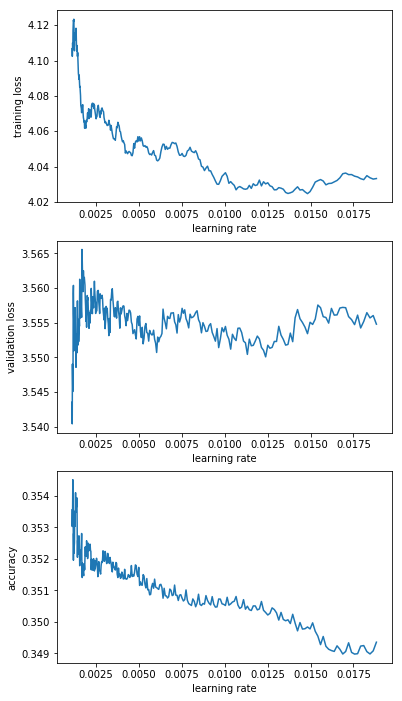

In [53]:
learn.sched.plot()

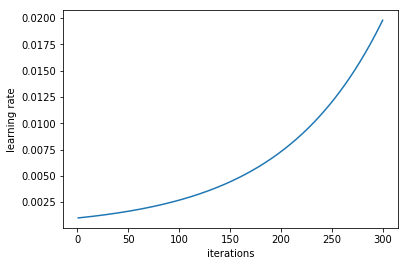

In [54]:
learn.sched.plot_lr()

In [55]:
lr= 5e-4
lrs = lr

In [56]:
learn.clip=0.12

In [57]:
learn.fit(lr, 2, cycle_len=10, use_clr_beta=(10,33,0.95,0.85), best_save_name='lm1_wgts')

epoch      trn_loss   val_loss   accuracy   
    0      4.022479   3.476816   0.364156  
    1      4.020699   3.47997    0.36424   
    2      4.006541   3.476923   0.364036  
    3      4.008779   3.473868   0.364264  
    4      4.011638   3.473658   0.363818  
    5      4.017908   3.480517   0.362459  
    6      4.010947   3.476857   0.363973  
    7      4.005714   3.472867   0.364137  
    8      4.005613   3.476999   0.362521  
    9      3.99907    3.479217   0.364044  
    10     4.014809   3.475479   0.364034  
    11     4.008263   3.47495    0.364164  
    12     4.000241   3.471992   0.364378  
    13     3.996208   3.476271   0.364359  
    14     4.000972   3.476538   0.362374  
    15     3.996927   3.471093   0.364535  
    16     4.002687   3.477917   0.363124  
    17     4.002131   3.474806   0.363718  
    18     4.001294   3.477789   0.363383  
    19     3.989939   3.472592   0.36431   


[array([3.47259]), 0.36431048275509675]

In [58]:
learn.load('lm1_wgts')
learn.save_encoder('lm1_enc')

## Classifier tokens

In [59]:
chunksize=24000

re1 = re.compile(r'  +')

In [60]:
df_trn = pd.read_csv(CLAS_PATH/'train.csv', header=None, chunksize=chunksize)
df_val = pd.read_csv(CLAS_PATH/'validation.csv', header=None, chunksize=chunksize)
df_tst = pd.read_csv(CLAS_PATH/'test.csv', header=None, chunksize=chunksize)

In [61]:
tok_trn, trn_labels = get_all(df_trn, 1)
tok_val, val_labels = get_all(df_val, 1)
tok_tst, tst_labels = get_all(df_tst, 1)

In [62]:
(CLAS_PATH/'tmp').mkdir(exist_ok=True)

In [63]:
np.save(CLAS_PATH/'tmp'/'tok_trn.npy', tok_trn)
np.save(CLAS_PATH/'tmp'/'tok_val.npy', tok_val)
np.save(CLAS_PATH/'tmp'/'tok_tst.npy', tok_tst)

In [64]:
np.save(CLAS_PATH/'tmp'/'trn_labels.npy', trn_labels)
np.save(CLAS_PATH/'tmp'/'val_labels.npy', val_labels)
# np.save(CLAS_PATH/'tmp'/'tst_labels.npy', tst_labels)

# df = pd.read_csv(CLAS_PATH/'test_labels.csv')
# df['label']=df['label'].replace(['N','P','NEU','NONE'],[0,1,2,3])
# np.save(CLAS_PATH/'tmp'/'tst_labels.npy', df['label'].values)

In [65]:
tok_trn = np.load(CLAS_PATH/'tmp'/'tok_trn.npy')
tok_val = np.load(CLAS_PATH/'tmp'/'tok_val.npy')
tok_tst = np.load(CLAS_PATH/'tmp'/'tok_tst.npy')

In [66]:
itos = pickle.load((TWEETSLM_PATH/'tmp'/'itos.pkl').open('rb'))
stoi = collections.defaultdict(lambda:0, {v:k for k,v in enumerate(itos)})
len(itos)

8321

In [67]:
trn_clas = np.array([[stoi[o] for o in p] for p in tok_trn])
val_clas = np.array([[stoi[o] for o in p] for p in tok_val])
tst_clas = np.array([[stoi[o] for o in p] for p in tok_tst])

In [68]:
np.save(CLAS_PATH/'tmp'/'trn_ids.npy', trn_clas)
np.save(CLAS_PATH/'tmp'/'val_ids.npy', val_clas)
np.save(CLAS_PATH/'tmp'/'tst_ids.npy', tst_clas)

## Classifier

In [69]:
trn_clas = np.load(CLAS_PATH/'tmp'/'trn_ids.npy')
val_clas = np.load(CLAS_PATH/'tmp'/'val_ids.npy')

In [70]:
trn_labels = np.squeeze(np.load(CLAS_PATH/'tmp'/'trn_labels.npy'))
val_labels = np.squeeze(np.load(CLAS_PATH/'tmp'/'val_labels.npy'))

In [71]:
bptt,em_sz,nh,nl = 70,400,1150,3
vs = len(itos)
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))
bs = 96

In [72]:
min_lbl = trn_labels.min()
trn_labels -= min_lbl
val_labels -= min_lbl
c=int(trn_labels.max())+1
print(c)

4


In the classifier, unlike LM, we need to read a tweet at a time. We do not deal with equal bptt size batches, so we have to pad the sequences to the same length in each batch. To create batches of similar sized movie tweets, we use a sortish sampler method invented by [@Smerity](https://twitter.com/Smerity) and [@jekbradbury](https://twitter.com/jekbradbury)

The sortishSampler cuts down the overall number of padding tokens the classifier ends up seeing.

In [73]:
trn_ds = TextDataset(trn_clas, trn_labels)
val_ds = TextDataset(val_clas, val_labels)
trn_samp = SortishSampler(trn_clas, key=lambda x: len(trn_clas[x]), bs=bs//2)
val_samp = SortSampler(val_clas, key=lambda x: len(val_clas[x]))
trn_dl = DataLoader(trn_ds, bs//2, transpose=True, num_workers=1, pad_idx=1, sampler=trn_samp)
val_dl = DataLoader(val_ds, bs, transpose=True, num_workers=1, pad_idx=1, sampler=val_samp)
md = ModelData(TWEETSLM_PATH, trn_dl, val_dl, test_dl=val_dl)

In [74]:
#dps = np.array([0.4,0.5,0.05,0.3,0.4])*0.8
dps = np.array([0.4,0.5,0.05,0.3,0.4])

In [75]:
m = get_rnn_classifer(bptt, 20*70, c, vs, emb_sz=em_sz, n_hid=nh, n_layers=nl, pad_token=1, layers=[em_sz*3, 50, c], drops=[dps[4], 0.1], dropouti=dps[0], wdrop=dps[1], dropoute=dps[2], dropouth=dps[3])

In [76]:
opt_fn = partial(optim.Adam, betas=(0.7, 0.99))

In [77]:
learn = RNN_Learner(md, TextModel(to_gpu(m)), opt_fn=opt_fn)
learn.reg_fn = partial(seq2seq_reg, alpha=2, beta=1)
learn.clip=.12
learn.metrics = [accuracy]

In [78]:
# wd = 1e-7
learn.load_encoder('lm1_enc')

In [79]:
learn.freeze_to(-1)

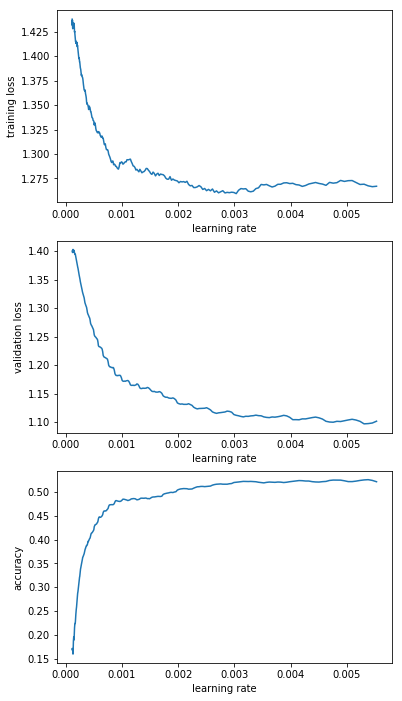

In [80]:
learn.lr_find2(start_lr=1e-4,end_lr=6e-3, num_it=300)
learn.sched.plot()

In [81]:
lr= 15e-4
lrm = 2.6
lrs = np.array([lr/(lrm**4), lr/(lrm**3), lr/(lrm**2), lr/lrm, lr])

In [82]:
learn.fit(lrs, 5, wds=wd, cycle_len=1, use_clr_beta=(32,10,0.8,0.7), best_save_name='clas2_0')

epoch      trn_loss   val_loss   accuracy   
    0      1.25691    1.090488   0.538471  
    1      1.225573   1.090339   0.545431  
    2      1.231149   1.080136   0.544271  
    3      1.213775   1.076788   0.54214   
    4      1.218043   1.076852   0.546188  


[array([1.07685]), 0.5461884420026433]

In [83]:
learn.load('clas2_0')

In [84]:
learn.freeze_to(-2)

In [85]:
learn.fit(lrs, 10, wds=wd, cycle_len=1, use_clr_beta=(32,10,0.8,0.7),  best_save_name='clas2_1')

epoch      trn_loss   val_loss   accuracy   
    0      1.196421   1.047254   0.56411   
    1      1.170302   1.053144   0.554688  
    2      1.169306   1.026757   0.586529  
    3      1.149911   1.02212    0.57706   
    4      1.152424   1.014886   0.57661   
    5      1.103032   1.007369   0.573982  
    6      1.123949   1.017522   0.567614  
    7      1.118455   1.004723   0.578598  
    8      1.101728   1.000115   0.571615  
    9      1.095938   1.004705   0.580634  


[array([1.0047]), 0.5806344744834033]

In [86]:
learn.load('clas2_1')

In [87]:
learn.unfreeze()

In [88]:
learn.fit(lr, 2, cycle_len=5, use_clr_beta=(32,10,0.8,0.7), best_save_name='final')

epoch      trn_loss   val_loss   accuracy   
    0      1.102569   1.045379   0.576444  
    1      1.031887   1.101668   0.516241  
    2      0.87576    0.988644   0.587003  
    3      0.67198    0.973142   0.618324  
    4      0.520726   0.960482   0.628764  
    5      0.495163   1.035127   0.611458  
    6      0.572342   1.195216   0.548201  
    7      0.486881   1.200542   0.563636  
    8      0.340436   1.255867   0.617898  
    9      0.263621   1.303111   0.615743  


[array([1.30311]), 0.6157433726570823]

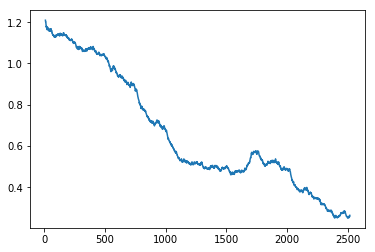

In [89]:
learn.load('final')
learn.sched.plot_loss()

## Model Evaluation

In [90]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [91]:
bs = 256
bptt,em_sz,nh,nl = 70,400,1150,3

tst_sent = np.load(CLAS_PATH/'tmp/tst_ids.npy')
tst_lbls = np.load(CLAS_PATH/'tmp/tst_labels.npy').flatten()
# tst_lbls -= tst_lbls.min()
c=4 #int(tst_lbls.max())+1
tst_ds = TextDataset(tst_sent, tst_lbls)
tst_samp = SortSampler(tst_sent, key=lambda x: len(tst_sent[x]))
tst_lbls_sampled = tst_lbls[list(tst_samp)]
tst_dl = DataLoader(tst_ds, bs, transpose=True, num_workers=1, pad_idx=1, sampler=tst_samp)
md = ModelData(TWEETSLM_PATH, None, tst_dl)
itos = pickle.load(open(TWEETSLM_PATH/'tmp/itos.pkl', 'rb'))
vs = len(itos)

F1(macro) =  0.45436851952129936
Accuracy  =  0.5218536071616641


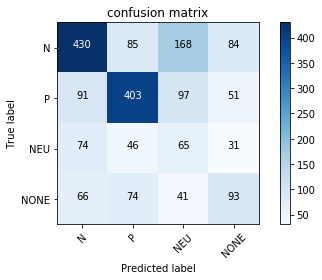

In [92]:
    
m = get_rnn_classifer(bptt, 20*70, c, vs, emb_sz=em_sz, n_hid=nh, n_layers=nl, pad_token=1, layers=[em_sz*3, 50, c], drops=[0., 0.])

learn = RNN_Learner(md, TextModel(to_gpu(m)))
learn.load_encoder('lm1_enc')
learn.load('final')
predictions = np.argmax(learn.predict(), axis=1)

f1 = f1_score(tst_lbls_sampled, predictions, average='macro')
print('F1(macro) = ', f1)

acc = (tst_lbls_sampled == predictions).mean()
print('Accuracy  = ', acc)


cnf_matrix = confusion_matrix(tst_lbls_sampled, predictions)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['N', 'P', 'NEU', 'NONE'], title='confusion matrix')
plt.show()

In [131]:
def getLabel(num):
    if num == 0:
        return 'N'
    elif num == 1:
        return 'P'
    elif num == 2:
        return 'NEU'
    elif num == 3:
        return 'NONE'

In [132]:
import xml.etree.ElementTree as ET

def putTestValue(xmlFIle, out):
    tree = ET.parse(xmlFIle)
    root = tree.getroot()

    tweets = []
    file = open(out,"w") 
    print(file)
    print(len(predictions))
    for i,tweet in enumerate(root.iter('tweet')): 
        val = getLabel(predictions[list(tst_samp).index(i)])
        ID = tweet.find('tweetid').text
        #print(ID)
        file.write(ID + "\t" + val + "\n")
    file.close() 

In [133]:
DATA_PATH = Path('D:/Maestria/NLP/AdvacedSentimentAnalysis/database/')
putTestValue(DATA_PATH/"TASS/TASS2018/task1-Test.xml", TWEETSLM_PATH/"output_ulmfit_2018.txt")

<_io.TextIOWrapper name='TWEETS_LM\\2017\\output_ulmfit_2018.txt' mode='w' encoding='cp1252'>
1899


In [134]:
print(TWEETSLM_PATH/"output_ulmfit_2018.txt")

TWEETS_LM\2017\output_ulmfit_2018.txt
